## SLI Training Script 
## By Luis A. Urso
## 27-JAN-2023 - version 1
##

In [26]:
import csv

import numpy as np
import tensorflow as tf
import pydot
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

RANDOM_SEED = 42

# Setup Global Variables

 Define the files path

In [5]:
dataset = 'model/training_data.csv'
model_save_path = 'model/training_classifierf.hdf5'
tflite_save_path = 'model/training_classifier.tflite'

Set number of classes

In [58]:
NUM_CLASSES = 3

# Dataset Preparation

Dataset loading

In [36]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [39]:
X_dataset.shape

(712, 42)

In [37]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [40]:
y_dataset.shape

(712,)

Split Data Sets into Train and Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Architecture & Building

FNN Model Arquitecture

In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [60]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


Model Pre-building Verification 

In [61]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

Model Compilation

In [62]:
# Model compilation

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [63]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/5 [=====>........................] - ETA: 3s - loss: 0.9105 - accuracy: 0.7656
Epoch 1: saving model to model\training_classifierf.hdf5
5/5 [==============================] - 2s 128ms/step - loss: 0.9018 - accuracy: 0.7472 - val_loss: 0.9117 - val_accuracy: 0.9438
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.8686 - accuracy: 0.7422
Epoch 2: saving model to model\training_classifierf.hdf5
5/5 [==============================] - 0s 31ms/step - loss: 0.8357 - accuracy: 0.7809 - val_loss: 0.8387 - val_accuracy: 0.9663
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.8257 - accuracy: 0.7891
Epoch 3: saving model to model\training_classifierf.hdf5
5/5 [==============================] - 0s 29ms/step - loss: 0.7852 - accuracy: 0.8109 - val_loss: 0.7659 - val_accuracy: 0.9663
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.7638 - accuracy: 0.8047
Epoch 4: saving model to model\training_classifierf.hdf5
5/5 [======

# Training Evaluation

In [64]:
# Model evaluation

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 2ms/step - loss: 8.1916e-06 - accuracy: 1.0000


In [65]:
# Loading the saved model

model = tf.keras.models.load_model(model_save_path)

In [66]:
# Inference Inference

predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 99ms/step
[7.7494697e-08 1.7050802e-06 9.9999821e-01]
2


# Confusion Matrix

6/6 [==============================] - 0s 2ms/step


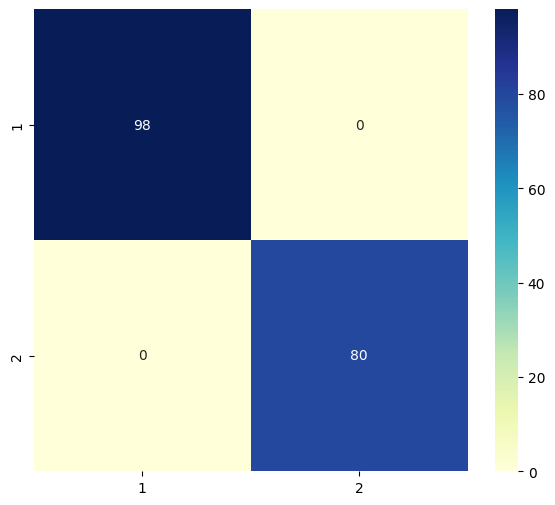

Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00        80

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap="YlGnBu")
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert Model for Tensorflow-Lite

In [69]:
# Save as a model dedicated to inference

model.save(model_save_path, include_optimizer=False)

In [70]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\URSO_L~1.COM\AppData\Local\Temp\tmpfdhutqte\assets


6496

# Inference Test

In [72]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [73]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [74]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [75]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.7494555e-08 1.7050769e-06 9.9999821e-01]
2
